<p><img src="https://www.carkeekwatershed.org/wp-content/uploads/CWCAPlogo-1.png" width="213" height="72"></p>

# CWCAP Salmon Survey Analysis
Press run all to generate all figures.

In [60]:
import requests, json, matplotlib.pyplot as plt, plotly.express as px, pandas as pd, IPython.core.display as ip
from datetime import datetime
from IPython.core.debugger import set_trace
import matplotlib.dates as mdates
mostRecentSurvey = '2021'
surveyURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f454667a28',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f454667a28',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f454667a28'}
salmonURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f509867795',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f509867795',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f509867795'}
        
def getEntries(uri):
    request = requests.get(url = uri)
    df = pd.DataFrame(pd.json_normalize(request.json()['data']['entries']))
    while request.json()['links']['next'] is not None:
        nextURL = request.json()['links']['next']
        request = requests.get(url = nextURL)
        df = df.append(pd.json_normalize(request.json()['data']['entries']))
    return df

def filterSalmonDf(salmonDf, *filters):
    for filter in filters:
        field, value = filter
        salmonDf = salmonDf.loc[(salmonDf[field] == value)]
    return salmonDf
    
def addStats(survey, salmonDf):
    surveyUUID = survey['ec5_uuid']
    todaySalmonDf = salmonDf[salmonDf['ec5_parent_uuid'] == surveyUUID]
    deadChum = filterSalmonDf(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Dead')).shape[0] + filterSalmonDf(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Remnant')).shape[0]
    deadCoho = filterSalmonDf(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Dead')).shape[0] + filterSalmonDf(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Remnant')).shape[0]
    deadUnknown = filterSalmonDf(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Dead')).shape[0] + filterSalmonDf(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Remnant')).shape[0]
    liveChum = filterSalmonDf(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Live')).shape[0]
    liveCoho = filterSalmonDf(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Live')).shape[0]
    liveUnknown = filterSalmonDf(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Live')).shape[0]
    liveSeaRunCutthroat = filterSalmonDf(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Live')).shape[0]
    liveResidentCutthroat = filterSalmonDf(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Live')).shape[0]
    liveCutthroat = liveSeaRunCutthroat + liveResidentCutthroat
    deadSeaRunCutthroat = filterSalmonDf(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Dead')).shape[0] + filterSalmonDf(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Remnant')).shape[0]
    deadResidentCutthroat = filterSalmonDf(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Dead')).shape[0] + filterSalmonDf(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Remnant')).shape[0]
    deadCutthroat = deadSeaRunCutthroat + deadResidentCutthroat
    redds = filterSalmonDf(todaySalmonDf, ('Type', 'Redd')).shape[0]
    totalDead = deadChum + deadCoho + deadSeaRunCutthroat + deadUnknown
    totalLiveSalmon = liveChum + liveCoho + liveUnknown
    total = totalDead + totalLiveSalmon #does not include redds or resident cutthroat
    return pd.Series({'Survey Date': pd.Timestamp(survey['Survey_Date']), 'Dead Chum': deadChum, 'Dead Coho': deadCoho, 'Live Chum': liveChum, 'Live Coho': liveCoho, 'Live Cutthroat': liveCutthroat, 'Dead Cutthroat': deadCutthroat, 'Redds': redds, 'Total Dead' : totalDead, 'Total Live Salmon': totalLiveSalmon, 'Total': total})

salmonDf = getEntries(salmonURIs.get(mostRecentSurvey))
surveyDf = getEntries(surveyURIs.get(mostRecentSurvey))
statsDf = surveyDf.apply(addStats, axis=1, args=[salmonDf]).groupby(['Survey Date']).sum().reset_index()
columnOrder =  ['Survey Date', 'Total Live Salmon', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho', 'Total Dead', 'Live Cutthroat', 'Dead Cutthroat', 'Redds']
statsDf = statsDf.sort_values(by=['Survey Date'])[columnOrder]
kwargs = {'Dead to Date' : statsDf['Total Dead'].cumsum(), 'Dead Chum to Date' : statsDf['Dead Chum'].cumsum(), 'Dead Coho to Date' : statsDf['Dead Coho'].cumsum()}
statsDf = statsDf.assign(**kwargs)
surveyDfs = {};
salmonDfs = {};
statsDfs = {};
for year in surveyURIs:
    surveyDfs[year] = getEntries(surveyURIs[year])
for year in salmonURIs:
    salmonDfs[year] = getEntries(salmonURIs[year])
for year in surveyDfs:
    if not salmonDfs[year].empty:
        statsDfs[year] = surveyDfs[year].apply(addStats, axis=1, args=[salmonDfs[year]]).groupby(['Survey Date']).sum().reset_index()
        statsDfs[year]['Survey Date'] = statsDfs[year]['Survey Date'].apply(lambda x: datetime.strptime(x.strftime("%m-%d"), "%m-%d"))

### Survey Stats Table

In [61]:
def displaySurveyStatsTable(statsDf):
    display(ip.HTML('<h3>Survey Totals</h3>'))
    display(ip.HTML(statsDf[['Survey Date', 'Total Live Salmon', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho', 'Live Cutthroat', 'Dead Cutthroat', 'Redds']].to_html(index=False)))
    display(ip.HTML('<i>Note: Total live salmon includes Sea-Run Cutthroat and Unknowns - entries where surveyors were unable to determine the species. Remnants are included in dead counts.</i>'))
    
def printYearlyTotals(statsDf):
    max = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).max()
    idxmax = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).idxmax()
    yearlySalmonTotal = int(max)
    yearlyChumTotal = int((statsDf['Dead Chum to Date']+statsDf['Live Chum']).max())
    yearlyCohoTotal = int((statsDf['Dead Coho to Date']+statsDf['Live Coho']).max())
    surveyOfCalculation = statsDf.iloc[idxmax]['Survey Date']
    display(ip.HTML('<h3>Yearly Totals</h3>'))
    yearlyTotals=pd.DataFrame({'Salmon': yearlySalmonTotal, 'Chum': yearlyChumTotal, 'Coho': yearlyCohoTotal, 'Based on survey': surveyOfCalculation}, index=[0])
    display(ip.HTML(yearlyTotals[['Salmon', 'Chum', 'Coho', 'Based on survey']].to_html(index=False)))
    display(ip.HTML('<i>Note: Yearly total is the survey date where (day\'s live + dead up to date) is max</i>'))
    ### DEBUGGING
    #print('Based on total dead count:', int(statsDf.iloc[idxmax]['Dead to Date']), '|', 'plus total live count:', int(statsDf.iloc[idxmax]['Total Live Salmon']))
    mergedDf = pd.merge(salmonDf, surveyDf, how='inner', left_on = 'ec5_parent_uuid', right_on = 'ec5_uuid')
    display(ip.HTML('<h3>Redds by location</h3>'))
    display(ip.HTML(filterSalmonDf(mergedDf, ('Type', 'Redd'))[['Distance', 'Survey_Date']].to_html(index=False)))
    
displaySurveyStatsTable(statsDf)
printYearlyTotals(statsDf)

Survey Date,Total Live Salmon,Live Chum,Dead Chum,Live Coho,Dead Coho,Live Cutthroat,Dead Cutthroat,Redds
2021-10-23,8,6,0,1,0,0,0,0
2021-10-26,33,27,0,4,3,1,0,3
2021-10-30,56,44,9,1,5,0,0,2
2021-11-02,94,91,12,1,4,1,0,14


Salmon,Chum,Coho,Based on survey
128,112,13,2021-11-02


Distance,Survey_Date
1970,11/02/2021
1750,11/02/2021
1675,11/02/2021
1550,11/02/2021
1400,11/02/2021
1125,11/02/2021
1060,11/02/2021
1000,11/02/2021
800,11/02/2021
690,11/02/2021


### Count Plot

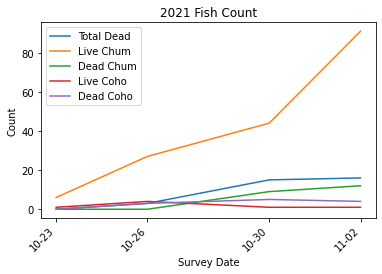

In [62]:
def displayCountPlot(statsDf):
    plot = statsDf.plot(ylabel = 'Count', title = mostRecentSurvey + ' Fish Count', rot=45, xticks=statsDf['Survey Date'], y=['Total Dead', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho'], x='Survey Date')
    plot.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
displayCountPlot(statsDf)

### Scatter Map

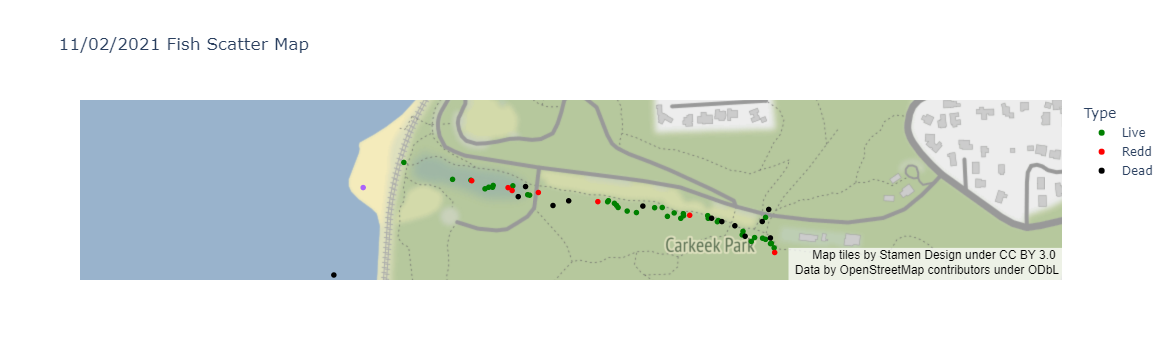

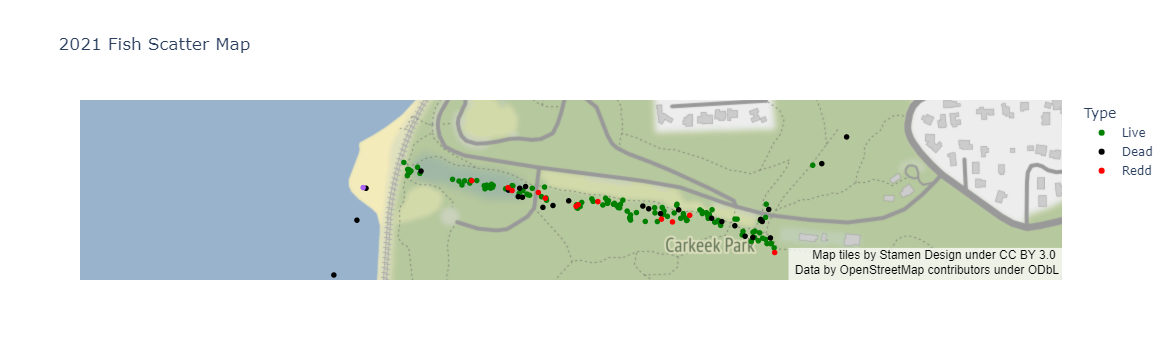

In [63]:
def displayScatterMap(salmonDf, figureTitle):    
    fig = px.scatter_mapbox(salmonDf, lat='Location.latitude', lon='Location.longitude', color='Type', labels={'Type':'Type'}, color_discrete_map={'Live': 'green', 'Redd': 'red', 'Dead': 'black'},
                        center=dict(lat=47.71157, lon=-122.3759), zoom=15, hover_name = 'title', hover_data = ['Location.accuracy'],
                        mapbox_style='stamen-terrain', title=figureTitle)
    fig.layout.coloraxis.showscale = False
    fig.show()
def dropInaccurateLocations(salmonDf):
    return salmonDf.loc[pd.to_numeric(salmonDf['Location.accuracy']) < 50]
mergedDf = pd.merge(salmonDf, surveyDf, how='inner', left_on = 'ec5_parent_uuid', right_on = 'ec5_uuid', suffixes=(None, '_y'))
mergedDf.sort_values(by=['Survey_Date'])
mostRecentSurveyDate = mergedDf.iloc[0]['Survey_Date']
displayScatterMap(dropInaccurateLocations(filterSalmonDf(mergedDf, ('Survey_Date', mostRecentSurveyDate))), mostRecentSurveyDate + ' Fish Scatter Map')
displayScatterMap(dropInaccurateLocations(salmonDf), mostRecentSurvey + ' Fish Scatter Map')  

### Spawned Chart

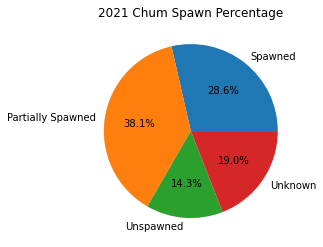

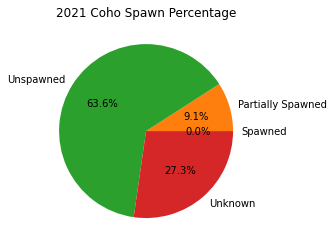

In [64]:
def displaySpawnedChart(salmonDf, species):
    try:
        deadDf = filterSalmonDf(salmonDf, ('Species', species), ('Type', 'Dead'))
        totalDead = deadDf.shape[0]
        totalSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Spawned')).shape[0]
        totalPartialSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Partially spawned')).shape[0]
        totalUnspawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Unspawned')).shape[0]
        totalUnknownSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Unknown')).shape[0]
        spawnPercentages = [totalSpawned/totalDead*100, totalPartialSpawned/totalDead*100, totalUnspawned/totalDead*100, totalUnknownSpawned/totalDead*100]
        pie, ax1 = plt.subplots()
        ax1.pie(spawnPercentages, labels=['Spawned', 'Partially Spawned', 'Unspawned', 'Unknown'], autopct='%1.1f%%')
        plt.title(mostRecentSurvey + ' ' + species + ' Spawn Percentage')
        plt.show()
    except ZeroDivisionError:
        print('Unable to display spawned chart. No spawning data to display')
displaySpawnedChart(salmonDf, 'Chum')
displaySpawnedChart(salmonDf, 'Coho')

### Year By Year Count

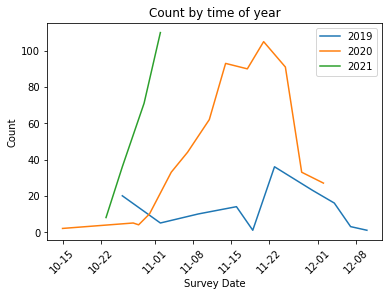

In [65]:
def displayYearByYearCount(surveyURIs, salmonURIs):

#plot each series
    fig, ax = plt.subplots()
    plt.plot('Survey Date', 'Total', data=statsDfs['2019'], label="2019")
    plt.plot('Survey Date', 'Total', data=statsDfs['2020'], label="2020")
    plt.plot('Survey Date', 'Total', data=statsDfs['2021'], label="2021")
    plt.title('Count by time of year')
    plt.ylabel('Count')
    plt.xlabel('Survey Date')
    plt.xticks(rotation = 45)
    plt.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

displayYearByYearCount(surveyURIs, salmonURIs)